In [1]:
import numpy as np

np.random.seed(0)
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (11.7, 8.27)})

In [2]:
def g(x):
    return np.tanh(x)


def g_der(x):
    return 1 - g(x) * g(x)

In [3]:
def center(X):
    X = np.array(X)
    mean = X.mean(axis=1, keepdims=True)
    return X - mean

In [4]:
def whitening(X):
    cov = np.cov(X)
    d, E = np.linalg.eigh(cov)
    D = np.diag(d)
    D_inv = np.sqrt(np.linalg.inv(D))
    X_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, X)))
    return X_whiten

In [5]:
def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean() * w
    w_new /= np.sqrt((w_new**2).sum())
    return w_new

In [6]:
def ica(X, iterations, tolerance=1e-5):
    X = center(X)
    X = whitening(X)
    components_nr = X.shape[0]

    W = np.zeros((components_nr, components_nr), dtype=X.dtype)
    for i in range(components_nr):
        w = np.random.rand(components_nr)

        for j in range(iterations):
            w_new = calculate_new_w(w, X)

            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])

            distance = np.abs(np.abs((w * w_new).sum()) - 1)

            w = w_new

            if distance < tolerance:
                break

        W[i, :] = w

    S = np.dot(W, X)

    return S

In [7]:
def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()

    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("mixtures")

    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("real sources")

    plt.subplot(3, 1, 3)
    for s in S:
        plt.plot(s)
    plt.title("predicted sources")

    fig.tight_layout()
    plt.show()

In [8]:
def mix_sources(mixtures, apply_noise=False):
    for i in range(len(mixtures)):
        max_val = np.max(mixtures[i])

        if max_val > 1 or np.min(mixtures[i]) < 1:
            mixtures[i] = mixtures[i] / (max_val / 2) - 0.5

    X = np.c_[[mix for mix in mixtures]]

    if apply_noise:
        X += 0.02 * np.random.normal(size=X.shape)

    return X

In [9]:
import pandas as pd

data = pd.read_csv("cash.csv")
data

,2019,2020,2021,2022,2023
0,64235,261863,274907,147517,280000
1,-76675,-84023,-122491,-63377,-100000
2,-12440,177840,152416,84140,180000
3,-50503,-91747,1394,-189616,0
4,278314,359252,523345,430778,0


In [10]:
d1 = np.array(data)[0, :]
d2 = np.array(data)[1, :]
d3 = np.array(data)[2, :]
d4 = np.array(data)[3, :]
d5 = np.array(data)[4, :]

X = mix_sources([d1, d2, d3, d4, d5])

C:\Users\91852\AppData\Local\Temp\ipykernel_22976\2701167057.py:5: RuntimeWarning: invalid value encountered in sqrt
  D_inv = np.sqrt(np.linalg.inv(D))


[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]


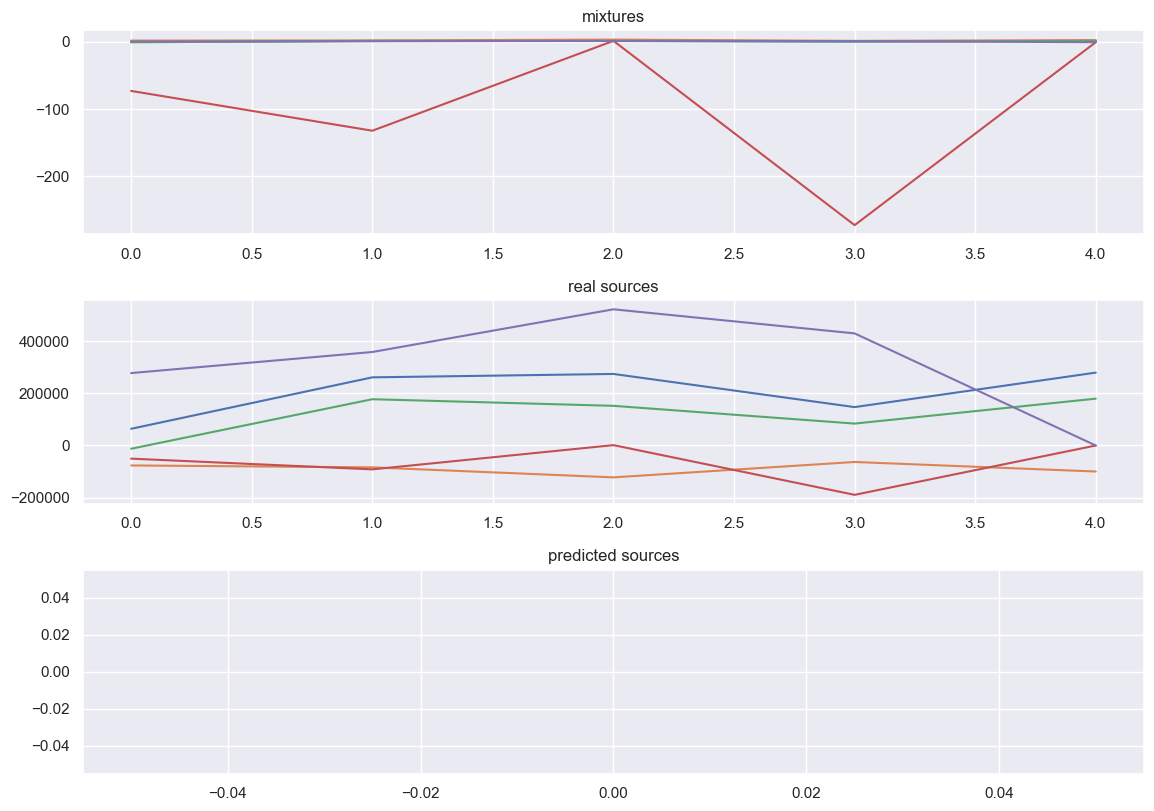

In [11]:
S = ica(X, iterations=1000)
print(S)

plot_mixture_sources_predictions(X, [d1, d2, d3, d4, d5], S)